# Build per-arm Bandit model with TF-Agents and execute locally with Vertex AI

## background

**Arm features**
* In some bandits use cases, each arm has its own features. For example, in movie recommendation problems, the user features play the role of the context and the movies play the role of the arms (aka actions) 
* Each movie has its own features, such as `text description`, `metadata`, `trailer content` features and so on

These problems are often referred to as `arm features problems`

In [1]:
! python3 -c "import google.cloud.aiplatform; print('aiplatform SDK version: {}'.format(google.cloud.aiplatform.__version__))"

aiplatform SDK version: 1.26.0


## Load env config

* use the prefix from `00-env-setup`

In [2]:
PREFIX = 'mabv1'

**run the next cell to populate env vars**

In [3]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "mabv1"
VERSION                  = "v1"

BUCKET_NAME              = "mabv1-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://mabv1-hybrid-vertex-bucket/data"
BUCKET_URI               = "gs://mabv1-hybrid-vertex-bucket"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_ID      = "hybrid-vertex.movielens_dataset_mabv1"
BIGQUERY_TABLE_ID        = "hybrid-vertex.movielens_dataset_mabv1.training_dataset"

REPO_DOCKER_PATH_PREFIX  = "src"
RL_SUB_DIR               = "per_arm_rl"



In [4]:
! gsutil ls $BUCKET_URI

gs://mabv1-hybrid-vertex-bucket/aiplatform-custom-training-2023-07-13-22:02:47.458/
gs://mabv1-hybrid-vertex-bucket/aiplatform-custom-training-2023-07-14-12:09:06.643/
gs://mabv1-hybrid-vertex-bucket/aiplatform-custom-training-2023-07-14-12:46:07.509/
gs://mabv1-hybrid-vertex-bucket/aiplatform-custom-training-2023-07-14-13:48:08.938/
gs://mabv1-hybrid-vertex-bucket/aiplatform-custom-training-2023-07-17-18:35:00.675/
gs://mabv1-hybrid-vertex-bucket/aiplatform-custom-training-2023-07-17-18:50:42.146/
gs://mabv1-hybrid-vertex-bucket/archived/
gs://mabv1-hybrid-vertex-bucket/config/
gs://mabv1-hybrid-vertex-bucket/data/
gs://mabv1-hybrid-vertex-bucket/perarm-local-test/
gs://mabv1-hybrid-vertex-bucket/scale-perarm-hpt-v2/
gs://mabv1-hybrid-vertex-bucket/scale-perarm-hpt-v3/
gs://mabv1-hybrid-vertex-bucket/scale-perarm-hpt/
gs://mabv1-hybrid-vertex-bucket/vocabs/


## imports

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
import functools
import json
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint
import pickle as pkl

import attr

import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf
from tf_agents.agents import TFAgent
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.bandits.environments import (environment_utilities,
                                            movielens_py_environment,
                                            movielens_per_arm_py_environment)
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import TFEnvironment, tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.metrics.tf_metric import TFStepMetric
from tf_agents.policies import policy_saver


from tf_agents.trajectories import time_step as ts
from tf_agents.specs import tensor_spec

# GPU
from numba import cuda 
import gc

# my project
from src.per_arm_rl import data_utils
from src.per_arm_rl import data_config

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

### detect GPUs & reset devices

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [9]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

### Initialize Google Cloud SDK Clients

In [10]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# Data prep

### Load data config

In [11]:
# # test variables are set
# print(f"USER_AGE_LOOKUP: {data_config.USER_AGE_LOOKUP}")
# print(f"USER_AGE_DIM: {data_config.USER_AGE_DIM}")

# print(f"USER_OCC_LOOKUP: {data_config.USER_OCC_LOOKUP}")
# print(f"USER_OCC_DIM: {data_config.USER_OCC_DIM}")

# print(f"MOVIE_GEN_LOOKUP: {data_config.MOVIE_GEN_LOOKUP}")
# print(f"MOVIE_GEN_DIM: {data_config.MOVIE_GEN_DIM}")

# print(f"MOVIELENS_NUM_MOVIES: {data_config.MOVIELENS_NUM_MOVIES}")
# print(f"MOVIELENS_NUM_USERS: {data_config.MOVIELENS_NUM_USERS}")

### Read TF Records

In [12]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

In [15]:
train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/train'):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files

['gs://mabv1-hybrid-vertex-bucket/data/train/ml-ratings-100k-train.tfrecord']

In [16]:
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils.parse_tfrecord)

for x in train_dataset.batch(1).take(1):
    pprint(x)

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([35.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[7]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'898'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([885409515])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'681'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'marketing'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}


## calculate lookups

In [19]:
GENERATE_VOCABS = False
print(f"GENERATE_VOCABS: {GENERATE_VOCABS}")

VOCAB_SUBDIR   = "vocabs"
VOCAB_FILENAME = "vocab_dict.pkl"

GENERATE_VOCABS: False


In [22]:
if not GENERATE_VOCABS:

    EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{VOCAB_SUBDIR}/{VOCAB_FILENAME}'
    print(f"Downloading vocab...")
    
    os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
    print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

    filehandler = open(VOCAB_FILENAME, 'rb')
    vocab_dict = pkl.load(filehandler)
    filehandler.close()
    
    for key in vocab_dict.keys():
        pprint(key)

Downloaded vocab from: gs://mabv1-hybrid-vertex-bucket/vocabs/vocab_dict.pkl

'movie_id'
'user_id'
'user_occupation_text'
'movie_genres'
'bucketized_user_age'
'max_timestamp'
'min_timestamp'
'timestamp_buckets'


### user featrues

In [23]:
if GENERATE_VOCABS:
    start_time = time.time()

    user_id_lookup = tf.keras.layers.StringLookup()
    user_id_lookup.adapt(train_dataset.map(lambda x: x["user_id"]))
    print(f"Vocabulary user_id_lookup: {user_id_lookup.get_vocabulary()[:3]}")

    end_time = time.time()
    runtime_mins = int((end_time - start_time) / 60)
    print(f"runtime_mins: {runtime_mins}")

In [24]:
if GENERATE_VOCABS:
    start_time = time.time()

    user_age_lookup = tf.keras.layers.IntegerLookup()
    user_age_lookup.adapt(train_dataset.map(lambda x: int(x["bucketized_user_age"])))
    print(f"Vocabulary user_age_lookup: {user_age_lookup.get_vocabulary()[:3]}")

    end_time = time.time()
    runtime_mins = int((end_time - start_time) / 60)
    print(f"runtime_mins: {runtime_mins}")

In [25]:
if GENERATE_VOCABS:
    start_time = time.time()

    user_occ_lookup = tf.keras.layers.StringLookup()
    user_occ_lookup.adapt(train_dataset.map(lambda x: x["user_occupation_text"]))
    print(f"Vocabulary user_age_lookup: {user_occ_lookup.get_vocabulary()[:3]}")

    end_time = time.time()
    runtime_mins = int((end_time - start_time) / 60)
    print(f"runtime_mins: {runtime_mins}")

In [26]:
if GENERATE_VOCABS:
    start_time = time.time()

    max_timestamp = train_dataset.map(lambda x: x["timestamp"]).reduce(
        tf.cast(0, tf.int64), tf.maximum).numpy().max()
    min_timestamp = train_dataset.map(lambda x: x["timestamp"]).reduce(
        np.int64(1e9), tf.minimum).numpy().min()

    timestamp_buckets = np.linspace(
        min_timestamp, max_timestamp, num=1000)

    print(f"Buckets: {timestamp_buckets[:3]}")

    end_time = time.time()
    runtime_mins = int((end_time - start_time) / 60)
    print(f"runtime_mins: {runtime_mins}\n")
    
    print(f"max_timestamp          : {max_timestamp}")
    print(f"min_timestamp          : {min_timestamp}")
    print(f"len(timestamp_buckets) : {len(timestamp_buckets)}")

### movie features

In [27]:
if GENERATE_VOCABS:
    start_time = time.time()

    movie_id_lookup = tf.keras.layers.StringLookup()
    movie_id_lookup.adapt(train_dataset.map(lambda x: x["movie_id"]))
    print(f"Vocabulary movie_id_lookup: {movie_id_lookup.get_vocabulary()[:3]}")

    end_time = time.time()
    runtime_mins = int((end_time - start_time) / 60)
    print(f"runtime_mins: {runtime_mins}")

In [28]:
if GENERATE_VOCABS:
    start_time = time.time()

    movie_gen_lookup = tf.keras.layers.IntegerLookup()
    movie_gen_lookup.adapt(train_dataset.map(lambda x: int(x["movie_genres"])))
    print(f"Vocabulary user_age_lookup: {movie_gen_lookup.get_vocabulary()[:3]}")

    end_time = time.time()
    runtime_mins = int((end_time - start_time) / 60)
    print(f"runtime_mins: {runtime_mins}")

## write vocabularies

In [29]:
print(f"PROJECT_ID      : {PROJECT_ID}")
print(f"BUCKET_NAME     : {BUCKET_NAME}")
print(f"VOCAB_SUBDIR    : {VOCAB_SUBDIR}")
print(f"VOCAB_FILENAME  : {VOCAB_FILENAME}")
print(f"GENERATE_VOCABS : {GENERATE_VOCABS}")

PROJECT_ID      : hybrid-vertex
BUCKET_NAME     : mabv1-hybrid-vertex-bucket
VOCAB_SUBDIR    : vocabs
VOCAB_FILENAME  : vocab_dict.pkl
GENERATE_VOCABS : False


In [30]:
if GENERATE_VOCABS:
    
    vocab_dict = {
        "movie_id" : movie_id_lookup.get_vocabulary(),
        "user_id" : user_id_lookup.get_vocabulary(),
        "user_occupation_text" : user_occ_lookup.get_vocabulary(), 
        "movie_genres" : movie_gen_lookup.get_vocabulary(),
        "bucketized_user_age" : user_age_lookup.get_vocabulary(),
        "max_timestamp" : max_timestamp,
        "min_timestamp" : min_timestamp,
        "timestamp_buckets" : timestamp_buckets,
    }
    
for key in vocab_dict.keys():
    pprint(key)

'movie_id'
'user_id'
'user_occupation_text'
'movie_genres'
'bucketized_user_age'
'max_timestamp'
'min_timestamp'
'timestamp_buckets'


In [38]:
filehandler = open(VOCAB_FILENAME, 'wb')
pkl.dump(vocab_dict, filehandler)

filehandler.close()

# data_utils.upload_blob(
#     project_id = PROJECT_ID, 
#     bucket_name = BUCKET_NAME, 
#     source_file_name = VOCAB_FILENAME, 
#     destination_blob_name =f"{VOCAB_SUBDIR}/{VOCAB_FILENAME}'
# )

File vocab_dict.pkl uploaded to gs://mabv1-hybrid-vertex-bucket/vocabs/vocab_dict.pkl.


## create embedding layers

In [86]:
USER_EMBEDDING_SIZE = 16

GENERATE_VOCABS = True
print(f"GENERATE_VOCABS: {GENERATE_VOCABS}")

GENERATE_VOCABS: True


### user features

In [87]:
if GENERATE_VOCABS:
    
    user_id_lookup = tf.keras.layers.StringLookup(
        vocabulary=vocab_dict['user_id'], 
        mask_token=None
    )
    
    user_id_embedding = tf.keras.layers.Embedding(
        # Let's use the explicit vocabulary lookup.
        input_dim=len(vocab_dict['user_id']) + 1,
        output_dim=USER_EMBEDDING_SIZE
    )

    # test 
    user_id_model = tf.keras.Sequential([user_id_lookup, user_id_embedding])
    print(user_id_model(["405"]))

tf.Tensor(
[[ 0.02643553 -0.04837246  0.02520958  0.04313285  0.04608935 -0.03655701
   0.0328645   0.04008532  0.04004509  0.03091248  0.04485698 -0.03180939
   0.00252942  0.00785595 -0.03558779  0.04265266]], shape=(1, 16), dtype=float32)


In [88]:
if GENERATE_VOCABS:
    
    user_age_lookup = tf.keras.layers.IntegerLookup(
        vocabulary=vocab_dict['bucketized_user_age'], 
        mask_token=None
    )
    
    user_age_embedding = tf.keras.layers.Embedding(
        # Let's use the explicit vocabulary lookup.
        input_dim=len(vocab_dict['bucketized_user_age']) + 1,
        output_dim=USER_EMBEDDING_SIZE
    )

    # test 
    user_age_model = tf.keras.Sequential([user_age_lookup, user_age_embedding])
    print(user_age_model([18]))

tf.Tensor(
[[-0.00077403 -0.03165146  0.00682945  0.04592332 -0.04784673 -0.0178473
   0.02218547  0.04141613  0.03842084  0.04235569  0.02343763  0.01226877
   0.02970822 -0.02869035 -0.01909477 -0.00442759]], shape=(1, 16), dtype=float32)


In [89]:
if GENERATE_VOCABS:
    
    user_occ_lookup = tf.keras.layers.StringLookup(
        vocabulary=vocab_dict['user_occupation_text'], 
        mask_token=None
    )
    
    user_occ_embedding = tf.keras.layers.Embedding(
        # Let's use the explicit vocabulary lookup.
        input_dim=len(vocab_dict['user_occupation_text']) + 1,
        output_dim=USER_EMBEDDING_SIZE
    )

    # test 
    user_occ_model = tf.keras.Sequential([user_occ_lookup, user_occ_embedding])
    print(user_occ_model(['student']))

tf.Tensor(
[[-0.04750245  0.033295    0.0498821   0.04788062  0.01069101 -0.04112743
   0.02875921  0.03240079 -0.04208798 -0.00935835  0.01056535 -0.03629487
   0.02404832 -0.0078624  -0.04410572  0.03484059]], shape=(1, 16), dtype=float32)


In [90]:
if GENERATE_VOCABS:
    
    timestamp_embedding_model = tf.keras.Sequential([
        tf.keras.layers.Discretization(vocab_dict['timestamp_buckets'].tolist()),
        tf.keras.layers.Embedding(
        input_dim = len(vocab_dict['timestamp_buckets'].tolist()) + 1,
        output_dim = USER_EMBEDDING_SIZE
        )
    ])

    print(timestamp_embedding_model([879024327]))

tf.Tensor(
[[ 0.03883174  0.00595482 -0.0399261  -0.03813168 -0.02039161  0.00847208
   0.00147634 -0.02288365  0.04881222 -0.04843555 -0.0398103   0.01920109
   0.04066057  0.03114004 -0.00720234  0.04290005]], shape=(1, 16), dtype=float32)


### movie features

In [92]:
MV_EMBEDDING_SIZE = 32

In [93]:
if GENERATE_VOCABS:
    
    movie_id_lookup = tf.keras.layers.StringLookup(
        vocabulary=vocab_dict['movie_id'], 
        mask_token=None
    )
    
    movie_id_embedding = tf.keras.layers.Embedding(
        # Let's use the explicit vocabulary lookup.
        input_dim=len(vocab_dict['movie_id']) + 1,
        output_dim=MV_EMBEDDING_SIZE
    )

    # test 
    mv_id_model = tf.keras.Sequential([movie_id_lookup, movie_id_embedding])
    print(mv_id_model(["357"]))

tf.Tensor(
[[ 0.03208871  0.03439878  0.04602    -0.03012394 -0.01692851 -0.01936519
   0.00424172  0.00924288  0.03015307  0.03785188  0.02235914  0.03427252
   0.03993554 -0.014408    0.04661101  0.04642868  0.00298477 -0.03250641
  -0.02521261 -0.04306735  0.04241886  0.01411592  0.00396633  0.02623018
  -0.03291987  0.04118882  0.01524312 -0.02079101  0.02770604  0.03157553
  -0.04032402  0.00941556]], shape=(1, 32), dtype=float32)


In [94]:
if GENERATE_VOCABS:
    
    movie_gen_lookup = tf.keras.layers.IntegerLookup(
        vocabulary=vocab_dict['movie_genres'], 
        mask_token=None
    )
    
    movie_gen_embedding = tf.keras.layers.Embedding(
        # Let's use the explicit vocabulary lookup.
        input_dim = len(vocab_dict['movie_genres']) + 1,
        output_dim = MV_EMBEDDING_SIZE
    )

    # test 
    mv_gen_model = tf.keras.Sequential([movie_gen_lookup, movie_gen_embedding])
    print(mv_gen_model([7]))

tf.Tensor(
[[ 0.01889816  0.0016728  -0.03355106 -0.03765643  0.00299264  0.00762732
   0.01840207  0.01055659  0.02957994 -0.01740841  0.0196997  -0.02774618
   0.01838609 -0.03414478  0.02179562 -0.0357976  -0.01485574 -0.00467642
  -0.0369582   0.0106835   0.04642207 -0.03707774 -0.04361224  0.04664365
  -0.01675395  0.00866444 -0.00726794 -0.04827648  0.00122297 -0.02867944
  -0.00778712  0.00371379]], shape=(1, 32), dtype=float32)


### test concat

In [95]:
for x in train_dataset.take(1).as_numpy_iterator():
    mv_id_value = x['movie_id']
    mv_gen_value = x['movie_genres'][0]

    print(mv_id_value)
    print(mv_gen_value)

    mv_id_emb = mv_id_model([str(mv_id_value.decode('utf-8'))])
    mv_gen_emb = mv_gen_model([int(mv_gen_value)])

    print(mv_id_emb.shape)
    print(mv_gen_emb.shape)

    # combined_mv_features = np.concatenate(
    #     (
    #         mv_id_emb,
    #         # tf.expand_dims(mv_gen_emb, axis=0)
    #         mv_gen_emb
    #     )
    #     , axis=1
    # )

b'898'
7
(1, 32)
(1, 32)


In [96]:
# if GENERATE_VOCABS:
    
#     test_user_id_value = user_id_model(["405"]).numpy()
#     print(f"test_user_id_value shape: {test_user_id_value.shape}")
    
#     test_age_value = user_age_model([18]).numpy()
#     print(f"test_age_value shape: {test_age_value.shape}")
    
#     test_occ_value = user_occ_model(['student']).numpy()
#     print(f"test_occ_value shape: {test_occ_value.shape}")
    
#     combined_user_features = np.concatenate(
#         (
#             test_id_value,
#             test_age_value,
#             test_occ_value
#         )
#         , axis=1
#     )
#     print(f"combined_user_features shape: {combined_user_features.shape}")

In [97]:
# inspect sample output values

# test_user_id_value
# test_age_value
# test_occ_value
# combined_user_features

# Bandit model components

## Create preprocessing layers

In [98]:
# from tf_agents.specs import tensor_spec
# from tf_agents.typing import types

# def _remove_num_actions_dim_from_spec(
#     observation_spec: types.NestedTensorSpec) -> types.NestedTensorSpec:
#     """Removes the extra `num_actions` dimension from the observation spec."""
#     obs_spec_no_num_actions = {
#         bandit_spec_utils.GLOBAL_FEATURE_KEY:
#             observation_spec[bandit_spec_utils.GLOBAL_FEATURE_KEY],
#         bandit_spec_utils.PER_ARM_FEATURE_KEY:
#               tensor_spec.remove_outer_dims_nest(
#                   observation_spec[bandit_spec_utils.PER_ARM_FEATURE_KEY], 1)
#     }
#     if bandit_spec_utils.NUM_ACTIONS_FEATURE_KEY in observation_spec:
#         obs_spec_no_num_actions.update(
#             {
#                 bandit_spec_utils.NUM_ACTIONS_FEATURE_KEY:
#                     observation_spec[bandit_spec_utils.NUM_ACTIONS_FEATURE_KEY]
#             }
#         )
#     return obs_spec_no_num_actions

## Environment

* A problem can be expressed in terms of an “environment”. 
* An environment is a class that generates observations (aka contexts), and also outputs a reward after being presented with actions

### global input functions

In [99]:
EMBEDDING_SIZE = 32

def global_context_sampling_fn():
    """
    This function generates a single global observation vector.
    """
    for x in train_dataset.take(1).as_numpy_iterator():
        user_id_value = x['user_id']
        user_age_value = x['bucketized_user_age']
        user_occ_value = x['user_occupation_text']
        user_ts_value = x['timestamp']
        
        # print(str(user_id_value.decode('utf-8')))
        # print(int(user_age_value))
        # print(user_occ_value.decode('utf-8'))
        # print(user_ts_value)
        
        id_emb = user_id_model([str(user_id_value.decode('utf-8'))])
        age_emb = user_age_model([int(user_age_value)])
        occ_emb = user_occ_model([user_occ_value.decode('utf-8')])
        ts_emb = timestamp_embedding_model([user_ts_value])
        
        id_emb = id_emb.numpy().flatten()
        age_emb = age_emb.numpy().flatten()
        occ_emb = occ_emb.numpy().flatten()
        ts_emb = ts_emb.numpy().flatten()

        # print(id_emb.shape)
        # print(age_emb.shape)
        # print(occ_emb.shape)
        # print(ts_emb.shape)

        combined_user_features = np.concatenate(
            (
                id_emb,
                age_emb,
                occ_emb,
                ts_emb
            )
            # , axis=1
        )

    return combined_user_features

In [100]:
global_con = global_context_sampling_fn()
print(global_con.shape)
global_con

(64,)


array([ 0.00769776, -0.04573976, -0.0261811 ,  0.04023675,  0.04622985,
       -0.00079228, -0.00541136,  0.043908  , -0.04173691,  0.00512675,
        0.0422282 ,  0.0171642 , -0.02895774, -0.02971119, -0.01044257,
       -0.00542693, -0.03533817,  0.01279868, -0.03364971,  0.00923642,
       -0.04242178, -0.03590107,  0.01860433,  0.01072677,  0.01419735,
        0.00567963, -0.03801296, -0.0496885 ,  0.00996801,  0.03778387,
        0.01609379, -0.02523093, -0.0285007 , -0.0064435 ,  0.0396492 ,
       -0.02235973,  0.00332198,  0.01274211,  0.03328785, -0.0231053 ,
       -0.00175345, -0.04737872, -0.01899226,  0.02813898, -0.03707448,
        0.02329678,  0.01369317, -0.00947405,  0.01162833, -0.0489178 ,
       -0.03983846, -0.0452021 ,  0.0439298 ,  0.03156736, -0.01282588,
       -0.03844577,  0.02086354, -0.0001248 ,  0.02945488, -0.04380796,
       -0.03299228, -0.01125817,  0.02525475, -0.01148219], dtype=float32)

In [101]:
def per_arm_context_sampling_fn():
    """
    This function generates a single per-arm observation vector
    """
    for x in train_dataset.take(1).as_numpy_iterator():
        mv_id_value = x['movie_id']
        mv_gen_value = x['movie_genres'][0]
        
#         print(mv_id_value)
#         print(mv_gen_value)
        
        mv_id_emb = mv_id_model([str(mv_id_value.decode('utf-8'))])
        mv_gen_emb = mv_gen_model([int(mv_gen_value)])
        
        # print(mv_id_emb)
        # print(mv_gen_emb)
        
        mv_id_emb = mv_id_emb.numpy().flatten()
        mv_gen_emb = mv_gen_emb.numpy().flatten()
        
#         print(mv_id_emb.shape)
#         print(mv_gen_emb.shape)
        
#         print(mv_id_emb)
#         print(mv_gen_emb)
        
        combined_mv_features = np.concatenate(
            (
                mv_id_emb,
                # tf.expand_dims(mv_gen_emb, axis=0)
                mv_gen_emb
            )
            # , axis=1
        )
        
    return combined_mv_features

In [102]:
global_arm = per_arm_context_sampling_fn()
print(global_arm.shape)
global_arm

# per_arm_context_sampling_fn()

(64,)


array([ 0.0332768 ,  0.00593678, -0.00208191, -0.02924472, -0.01904194,
        0.01460986, -0.01240771,  0.00024797, -0.01759089,  0.02789576,
        0.00131166, -0.00170441, -0.04726017, -0.00814946,  0.03647418,
       -0.01625798, -0.00200064,  0.02109562,  0.04405464,  0.00964594,
       -0.02885385,  0.02938526, -0.02521946,  0.00513027, -0.02299463,
        0.03293708, -0.00691509,  0.04698566, -0.01175486, -0.01108911,
       -0.00803708, -0.04117299,  0.01889816,  0.0016728 , -0.03355106,
       -0.03765643,  0.00299264,  0.00762732,  0.01840207,  0.01055659,
        0.02957994, -0.01740841,  0.0196997 , -0.02774618,  0.01838609,
       -0.03414478,  0.02179562, -0.0357976 , -0.01485574, -0.00467642,
       -0.0369582 ,  0.0106835 ,  0.04642207, -0.03707774, -0.04361224,
        0.04664365, -0.01675395,  0.00866444, -0.00726794, -0.04827648,
        0.00122297, -0.02867944, -0.00778712,  0.00371379], dtype=float32)

### reward function

In [103]:
PARAM_BOUND = 10
GLOBAL_DIM = global_con.shape[0]
PER_ARM_DIM = global_arm.shape[0]
VARIANCE = 100.0

reward_param = list(np.random.randint(
      -PARAM_BOUND, PARAM_BOUND, [GLOBAL_DIM + PER_ARM_DIM]))

# reward_param

In [104]:
# inner_prod = np.dot(global_arm[0], global_con[0])
# inner_prod

In [105]:
def linear_normal_reward_fn(x):
    """This function generates a reward from the concatenated global and per-arm observations."""
    mu = np.dot(x, reward_param)
    return np.random.normal(mu, VARIANCE)

### set environment

In [106]:
# The dimension of the global features.
GLOBAL_DIM = global_con.shape[0]
PER_ARM_DIM = global_arm.shape[0] 
# The elements of the PER-ARM feature will be integers in [-PER_ARM_BOUND, PER_ARM_BOUND).

NUM_ACTIONS = 32 
BATCH_SIZE = 20

# The variance of the Gaussian distribution that generates the rewards.
VARIANCE = 100.0
PARAM_BOUND = 10

print(f"GLOBAL_DIM   : {GLOBAL_DIM}")
print(f"PER_ARM_DIM  : {PER_ARM_DIM}")
print(f"NUM_ACTIONS  : {NUM_ACTIONS}")
print(f"BATCH_SIZE   : {BATCH_SIZE}")

GLOBAL_DIM   : 64
PER_ARM_DIM  : 64
NUM_ACTIONS  : 32
BATCH_SIZE   : 20


In [107]:
from tf_agents.bandits.environments import stationary_stochastic_per_arm_py_environment as p_a_env

per_arm_py_env = p_a_env.StationaryStochasticPerArmPyEnvironment(
    global_context_sampling_fn,
    per_arm_context_sampling_fn,
    NUM_ACTIONS,
    linear_normal_reward_fn,
    batch_size=BATCH_SIZE
)
per_arm_tf_env = tf_py_environment.TFPyEnvironment(per_arm_py_env)

In [108]:
print('observation spec: ', per_arm_tf_env.observation_spec())

observation spec:  {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(32, 64), dtype=tf.float32, name=None)}


In [109]:
start_time = time.time()
print('\nAn observation: ', per_arm_tf_env.reset().observation)

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"runtime_mins: {runtime_mins}")


An observation:  {'global': <tf.Tensor: shape=(20, 64), dtype=float32, numpy=
array([[ 0.00769776, -0.04573976, -0.0261811 , ..., -0.01125817,
         0.02525475, -0.01148219],
       [ 0.00769776, -0.04573976, -0.0261811 , ..., -0.01125817,
         0.02525475, -0.01148219],
       [ 0.00769776, -0.04573976, -0.0261811 , ..., -0.01125817,
         0.02525475, -0.01148219],
       ...,
       [ 0.00769776, -0.04573976, -0.0261811 , ..., -0.01125817,
         0.02525475, -0.01148219],
       [ 0.00769776, -0.04573976, -0.0261811 , ..., -0.01125817,
         0.02525475, -0.01148219],
       [ 0.00769776, -0.04573976, -0.0261811 , ..., -0.01125817,
         0.02525475, -0.01148219]], dtype=float32)>, 'per_arm': <tf.Tensor: shape=(20, 32, 64), dtype=float32, numpy=
array([[[ 0.0332768 ,  0.00593678, -0.00208191, ..., -0.02867944,
         -0.00778712,  0.00371379],
        [ 0.0332768 ,  0.00593678, -0.00208191, ..., -0.02867944,
         -0.00778712,  0.00371379],
        [ 0.0332768 , 

In [110]:
action = tf.zeros(BATCH_SIZE, dtype=tf.int32)
action

<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)>

In [111]:
time_step = per_arm_tf_env.step(action)
print('\nRewards after taking an action: ', time_step.reward)


Rewards after taking an action:  tf.Tensor(
[-9.20845795e+01  6.28346901e+01 -9.77791214e+01  3.48323178e+00
  1.23169876e+02  5.20816002e+01 -6.11318665e+01  8.65554581e+01
  8.15191498e+01 -8.82366257e+01 -1.70474172e-01 -2.20726028e+02
 -1.46828629e+02 -1.47762375e+02 -2.70863800e+01  3.39633598e+01
 -2.09574570e+02 -1.19612350e+02 -1.27088997e+02  1.25970444e+02], shape=(20,), dtype=float32)


## LinUCB Agent

In [112]:
observation_spec = per_arm_tf_env.observation_spec()
observation_spec

{'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(32, 64), dtype=tf.float32, name=None)}

In [113]:
time_step_spec = ts.time_step_spec(observation_spec)
time_step_spec

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(32, 64), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [114]:
action_spec = tensor_spec.BoundedTensorSpec(
    dtype=tf.int32, shape=(), minimum=0, maximum=NUM_ACTIONS - 1)

action_spec

BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(31, dtype=int32))

In [115]:
agent = lin_ucb_agent.LinearUCBAgent(time_step_spec=time_step_spec,
                                     action_spec=action_spec,
                                     accepts_per_arm_features=True)

agent

### The Flow of Training Data

In [116]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(31, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=(), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(64,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


In [117]:
print('observation spec in training: ', agent.training_data_spec.observation)

observation spec in training:  {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None)}


In [118]:
print('chosen arm features: ', agent.training_data_spec.policy_info.chosen_arm_features)

chosen arm features:  TensorSpec(shape=(64,), dtype=tf.float32, name=None)


## Regret Metric

Bandits' most important metric is **regret**, calculated as the difference between the reward collected by the agent and the expected reward of an oracle policy that has access to the reward functions of the environment. The [RegretMetric](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/metrics/tf_metrics.py) thus needs a `baseline_reward_fn` function that calculates the best achievable expected reward given an observation. For our example, we need to take the maximum of the no-noise equivalents of the reward functions that we already defined for the environment.

In [139]:
def _all_rewards(observation, hidden_param):
    """Outputs rewards for all actions, given an observation."""
    hidden_param = tf.cast(hidden_param, dtype=tf.float32)
    global_obs = observation['global']
    per_arm_obs = observation['per_arm']
    num_actions = tf.shape(per_arm_obs)[1]
    tiled_global = tf.tile(
        tf.expand_dims(global_obs, axis=1), [1, num_actions, 1])
    concatenated = tf.concat([tiled_global, per_arm_obs], axis=-1)
    rewards = tf.linalg.matvec(concatenated, hidden_param)
    return rewards

def optimal_reward(observation):
    """Outputs the maximum expected reward for every element in the batch."""
    return tf.reduce_max(_all_rewards(observation, reward_param), axis=1)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward)

In [142]:
# ====================================================
# metrics
# ====================================================

# `step_metric` records the number of individual rounds of bandit interaction;
# that is, (number of trajectories) * batch_size.
step_metric = tf_metrics.EnvironmentSteps()

metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.AverageEpisodeLengthMetric(batch_size=per_arm_tf_env.batch_size)
]

if isinstance(per_arm_tf_env.reward_spec(), dict):
    metrics += [
        tf_metrics.AverageReturnMultiMetric(
            reward_spec=per_arm_tf_env.reward_spec(),
            batch_size=per_arm_tf_env.batch_size)
    ]
else:
    metrics += [
        tf_metrics.AverageReturnMetric(batch_size=per_arm_tf_env.batch_size)
    ]

In [143]:
metrics

## Train loop

In [144]:
EXPERIMENT_NAME   = f'custom-neural-bandits-v1'

invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

LOG_DIR           = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/tb-logs"
ROOT_DIR          = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : custom-neural-bandits-v1
RUN_NAME          : run-20230720-062655
LOG_DIR           : gs://mabv1-hybrid-vertex-bucket/custom-neural-bandits-v1/run-20230720-062655/tb-logs
ROOT_DIR          : gs://mabv1-hybrid-vertex-bucket/custom-neural-bandits-v1/run-20230720-062655/root
ARTIFACTS_DIR     : gs://mabv1-hybrid-vertex-bucket/custom-neural-bandits-v1/run-20230720-062655/artifacts


In [145]:
num_iterations = 5 # @param
steps_per_loop = 1 # @param

In [146]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=steps_per_loop)

replay_buffer

In [147]:
# observers = [replay_buffer.add_batch, regret_metric]
observers = [replay_buffer.add_batch, regret_metric] + metrics

observers

[<bound method ReplayBuffer.add_batch of <tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer object at 0x7fc6846b43a0>>,

In [148]:
driver = dynamic_step_driver.DynamicStepDriver(
    env=per_arm_tf_env,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * BATCH_SIZE,
    observers=observers
)

driver

In [155]:
print(f"num_iterations = {num_iterations}")
print(f"steps_per_loop = {steps_per_loop}")

num_iterations = 5
steps_per_loop = 1


In [156]:
from tf_agents.eval import metric_utils
from tf_agents.metrics import export_utils
from src.per_arm_rl import train_utils

def train_perarm(
    num_iterations: int,
    steps_per_loop: int,
    start_profiling_step: int,
    stop_profiling_step: int,
    profiling_log_dir: str,
    log_interval: int = 1,
    additional_metrics: Optional[List[TFStepMetric]] = None,
) -> Dict[str, List[float]]:
#     # ====================================================
#     # metrics
#     # ====================================================
    
#     # `step_metric` records the number of individual rounds of bandit interaction;
#     # that is, (number of trajectories) * batch_size.
#     step_metric = tf_metrics.EnvironmentSteps()

#     metrics = [
#         tf_metrics.NumberOfEpisodes(),
#         tf_metrics.AverageEpisodeLengthMetric(batch_size=per_arm_tf_env.batch_size)
#     ]

    metrics = []
    if additional_metrics:
        metrics += additional_metrics

#     if isinstance(per_arm_tf_env.reward_spec(), dict):
#         metrics += [
#             tf_metrics.AverageReturnMultiMetric(
#                 reward_spec=per_arm_tf_env.reward_spec(),
#                 batch_size=per_arm_tf_env.batch_size)
#         ]
#     else:
#         metrics += [
#             tf_metrics.AverageReturnMetric(batch_size=per_arm_tf_env.batch_size)
#         ]

    # Store intermediate metric results, indexed by metric names.
    metric_results = defaultdict(list)

    # ====================================================
    # train loop
    # ====================================================
    @tf.function(autograph=False)
    def train_step():
        return agent.train(replay_buffer.gather_all())

    regret_values = []
    # log_interval = 1

    #start the timer and training
    print(f"starting train loop...")
    start_time = time.time()

    for step in range(num_iterations):
        
        start_step_time = time.time()
        
        if step == start_profiling_step:
            print(f"profiler initialized...")
            tf.profiler.experimental.start(logdir=profiling_log_dir)
        if step == stop_profiling_step:
            print(f"stopping profiler...")
            tf.profiler.experimental.stop(save=True)
            
        driver.run()

        train_utils._export_metrics_and_summaries(
            step=step, metrics=metrics
        )
        # loss_info = agent.train(replay_buffer.gather_all())
        loss_info = train_step()

        replay_buffer.clear()
        regret_values.append(regret_metric.result())

        step_time = int((time.time() - start_step_time) / 60)
        if log_interval and step % log_interval == 0:
            print('step = {0}: loss = {1}; execution time: {2}'.format(step, round(loss_info.loss.numpy(), 2), step_time))

        export_utils.export_metrics(
            step=step,
            metrics=[],
            loss_info=loss_info
        )

        metric_utils.log_metrics(metrics)
        for metric in metrics:
            metric.tf_summaries(train_step=step_metric.result())
            metric_results[type(metric).__name__].append(metric.result().numpy())

        # print(f"step: {step} completed in {step_time}")

    runtime_mins = int((time.time() - start_time) / 60)
    print(f"runtime_mins: {runtime_mins}")
    
    return metric_results
    # return metric_results, regret_values

In [ ]:
# metric_results, regret_values = train_actor_net(
metric_results = train_perarm(
    num_iterations = num_iterations,
    steps_per_loop = steps_per_loop,
    start_profiling_step=1,
    stop_profiling_step=2,
    log_interval = 1,
    additional_metrics = [regret_metric] + metrics,
    profiling_log_dir=LOG_DIR
)

pprint(metric_results)

starting train loop...


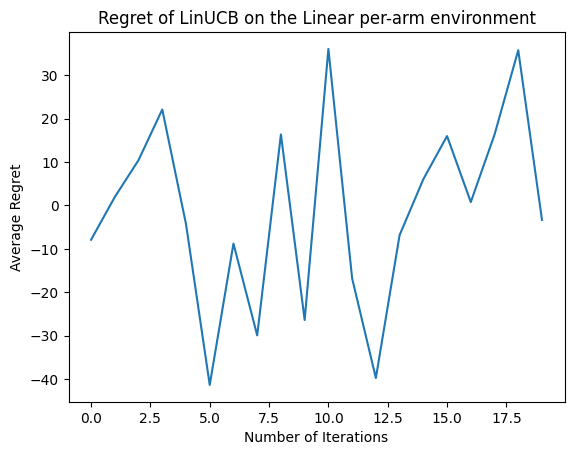

In [143]:
plt.plot(regret_values)
plt.title('Regret of LinUCB on the Linear per-arm environment')
plt.xlabel('Number of Iterations')
_ = plt.ylabel('Average Regret')

### TensorBoard

In [ ]:
%load_ext tensorboard
# %reload_ext tensorboard

In [ ]:
%tensorboard --logdir=$LOG_DIR

# Encoding Network(s)

An actor policy can be created using either:
* a network that maps `time_steps` to `actions` 
* or a network that maps `time_steps` to *distributions* over `actions`.

**Main Networks:**
* `ActorNetworks`: Learn a mapping from observations to actions. These networks are usually used by our policies to generate actions.
* `ActorDistributionNetworks`: Similar to ActorNetworks but these generate a distribution which a policy can then sample to generate actions.

**Helper Networks**
* `EncodingNetwork`: Allows users to easily define a mapping of pre-processing layers to apply to a network's input.

> see all `Network` types and details in the [Networks tutorial](https://www.tensorflow.org/agents/tutorials/8_networks_tutorial#encodingnetwork)

## Actor Networks

* in TF, most network layers are designed for batch operations, so we expect the input `time_steps` to be batched, and the output of the network will be batched as well
* the network is responsible for producing `actions` in the correct range of the given action_spec 
* This is conventionally done using e.g. a `tanh activation` for the final layer to produce actions in [-1, 1] and then scaling and shifting this to the correct range as the input action_spec (see `tf_agents/agents/ddpg/networks.actor_network()`)

In [195]:
from tf_agents.networks import network
from tf_agents.networks import encoding_network
from tf_agents.utils import nest_utils
from tf_agents.utils import common as common_utils
from tf_agents.networks import utils

class ActorNetwork(network.Network):

    def __init__(
        self,
        observation_spec,
        action_spec,
        preprocessing_layers=None,
        preprocessing_combiner=None,
        conv_layer_params=None,
        fc_layer_params=(75, 40),
        dropout_layer_params=None,
        activation_fn=tf.keras.activations.relu,
        enable_last_layer_zero_initializer=False,
        name='ActorNetwork'
    ):
        super(ActorNetwork, self).__init__(
            input_tensor_spec=observation_spec, 
            state_spec=(), 
            name=name
        )
        
        # For simplicity we will only support a single action float output.
        self._action_spec = action_spec

        flat_action_spec = tf.nest.flatten(action_spec)
        if len(flat_action_spec) > 1:
            raise ValueError('Only a single action is supported by this network')

        self._single_action_spec = flat_action_spec[0]
        # if self._single_action_spec.dtype not in [tf.float32, tf.float64]:
        #     raise ValueError('Only float actions are supported by this network.')

        kernel_initializer = tf.keras.initializers.VarianceScaling(
            scale=1. / 3., 
            mode='fan_in', 
            distribution='uniform'
        )
        self._encoder = encoding_network.EncodingNetwork(
            observation_spec,
            preprocessing_layers=preprocessing_layers,
            preprocessing_combiner=preprocessing_combiner,
            conv_layer_params=conv_layer_params,
            fc_layer_params=fc_layer_params,
            dropout_layer_params=dropout_layer_params,
            activation_fn=activation_fn,
            kernel_initializer=kernel_initializer,
            batch_squash=False
        )

        initializer = tf.keras.initializers.RandomUniform(
            minval=-0.003, maxval=0.003)

        self._action_projection_layer = tf.keras.layers.Dense(
            flat_action_spec[0].shape.num_elements(),
            activation=tf.keras.activations.tanh,
            kernel_initializer=initializer,
            name='action')

    def call(self, observations, step_type=(), network_state=()):
        outer_rank = nest_utils.get_outer_rank(observations, self.input_tensor_spec)
        # We use batch_squash here in case the observations have a time sequence
        # compoment.
        batch_squash = utils.BatchSquash(outer_rank)
        observations = tf.nest.map_structure(batch_squash.flatten, observations)

        state, network_state = self._encoder(
            observations, step_type=step_type, network_state=network_state)
        actions = self._action_projection_layer(state)
        actions = common_utils.scale_to_spec(actions, self._single_action_spec)
        actions = batch_squash.unflatten(actions)
        return tf.nest.pack_sequence_as(self._action_spec, [actions]), network_state

In [196]:
print('observation spec: ', per_arm_tf_env.observation_spec())

observation spec:  {'global': TensorSpec(shape=(128,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(70, 128), dtype=tf.float32, name=None)}


### preprocess layers: option 1

In [208]:
layer_sizes = [128, 64]
seed = 42

In [209]:
# =====================================
# user feature layers
# =====================================

global_dense_layers = tf.keras.Sequential(name="global_dense_layers")

for layer_size in layer_sizes:
    global_dense_layers.add(
        tf.keras.layers.Dense(
            layer_size,
            activation="relu", 
            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed),
        )
    )

# normalization layer
# global_dense_layers.add(tf.keras.layers.LayerNormalization(name="normalize_dense"))
        
# =====================================
# movie feature layers
# =====================================

perarm_dense_layers = tf.keras.Sequential(name="perarm_dense_layers")

for layer_size in layer_sizes:
    perarm_dense_layers.add(
        tf.keras.layers.Dense(
            layer_size,
            activation="relu", 
            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed),
        )
    )

# normalization layer
# perarm_dense_layers.add(tf.keras.layers.LayerNormalization(name="normalize_dense"))

# =====================================
# layer dict
# =====================================
preprocessing_layers = {
    'global': global_dense_layers,
    'per_arm': perarm_dense_layers
}

preprocessing_combiner = tf.keras.layers.Concatenate(axis=-1)

In [210]:
per_arm_tf_env.observation_spec()

{'global': TensorSpec(shape=(128,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(70, 128), dtype=tf.float32, name=None)}

In [211]:
per_arm_tf_env.action_spec()

BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(69, dtype=int32))

In [212]:
actor = ActorNetwork(
    per_arm_tf_env.observation_spec(), 
    per_arm_tf_env.action_spec(),
    preprocessing_layers=preprocessing_layers,
    preprocessing_combiner=preprocessing_combiner
)

In [ ]:
start_time = time.time()

time_step = per_arm_tf_env.reset()

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"runtime_mins: {runtime_mins}")

time_step

In [203]:
actor(time_step.observation, time_step.step_type)

2023-07-20 04:34:15.149670: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.2.0 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.


InternalError: Exception encountered when calling layer 'normalize_dense' (type LayerNormalization).

{{function_node __wrapped__FusedBatchNormV3_device_/job:localhost/replica:0/task:0/device:GPU:0}} cuDNN launch failure : input shape ([1,20,32,1]) [Op:FusedBatchNormV3]

Call arguments received by layer 'normalize_dense' (type LayerNormalization):
  • inputs=tf.Tensor(shape=(20, 32), dtype=float32)

### preprocess layers: option 2

In [ ]:
# # =====================================
# # user feature layers
# # =====================================

# # user id
# user_id_emb_layer = tf.keras.Sequential([
#     tf.keras.layers.StringLookup(
#         vocabulary=vocab_dict['user_id'], 
#         mask_token=None
#     ),
#     tf.keras.layers.Embedding(
#         input_dim = data_config.MOVIELENS_NUM_USERS + 1, 
#         output_dim = 32
#     ),
# ])

# # user age bucketized
# user_age_emb_layer = tf.keras.Sequential([
#     tf.keras.layers.IntegerLookup(
#         vocabulary=vocab_dict['bucketized_user_age'], 
#         mask_token=None
#     ),
#     tf.keras.layers.Embedding(
#         input_dim = len(vocab_dict['bucketized_user_age']) + 1, 
#         output_dim = 32
#     ),
# ])

# # user occ bucketized
# user_occ_emb_layer = tf.keras.Sequential([
#     tf.keras.layers.StringLookup(
#         vocabulary=vocab_dict['user_occupation_text'], 
#         mask_token=None
#     ),
#     tf.keras.layers.Embedding(
#         input_dim = len(vocab_dict['user_occupation_text']) + 1, 
#         output_dim = 32
#     ),
# ])

# timestamp_emb_layer = tf.keras.Sequential([
#     tf.keras.layers.Discretization(vocab_dict['timestamp_buckets'].tolist()),
#     tf.keras.layers.Embedding(
#         input_dim = len(vocab_dict['timestamp_buckets'].tolist()) + 1, 
#         output_dim = 32
#     ),
# ])

# # =====================================
# # movie feature layers
# # =====================================

# # movie ID
# mv_id_emb_layer = tf.keras.Sequential([
#     tf.keras.layers.StringLookup(
#         vocabulary=vocab_dict['movie_id'], 
#         mask_token=None
#     ),
#     tf.keras.layers.Embedding(
#         input_dim = data_config.MOVIELENS_NUM_MOVIES + 1, 
#         output_dim = 32
#     ),
# ])
    
# # movie genres
# mv_gen_emb_layer = tf.keras.Sequential([
#     tf.keras.layers.IntegerLookup(
#         vocabulary=vocab_dict['movie_genres'], 
#         mask_token=None
#     ),
#     tf.keras.layers.Embedding(
#         input_dim = len(vocab_dict['movie_genres']) + 1, 
#         output_dim = 32
#     ),
# ])

In [150]:
data_config.MOVIELENS_NUM_USERS

943

In [156]:
len(vocab_dict['movie_genres'])

# len(vocab_dict['timestamp_buckets'].tolist())

20

### multiple per-arm features in observation spec

```
  obs_spec = {
      utils.GLOBAL_FEATURE_KEY:
          tensor_spec.TensorSpec(shape=(global_dim,), dtype=tf.float32),
      utils.PER_ARM_FEATURE_KEY: {
          'doc_id':
              tensor_spec.TensorSpec(
                  shape=(hparams.num_docs_to_rank,), dtype=tf.int64),
          'app_region_tag':
              tensor_spec.TensorSpec(
                  shape=(hparams.num_docs_to_rank,), dtype=tf.string),
          'app_language_tag':
              tensor_spec.TensorSpec(
                  shape=(hparams.num_docs_to_rank,), dtype=tf.string)
      }
  }
 ```

In [ ]:
movie_id_lookup = tf.keras.layers.StringLookup(
    vocabulary=vocab_dict['movie_id'], 
    mask_token=None
)
action_vocab_size = movie_id_lookup.vocabulary_size()

# Train RL modules

## Train (locally)

A **policy** in a bandit problem works the same way as in an RL problem: it provides an action (or a distribution of actions), given an observation as input.
* For more details, see the [TF-Agents Policy tutorial](https://github.com/tensorflow/agents/blob/master/docs/tutorials/3_policies_tutorial.ipynb).
* As with environments, there are two ways to construct a policy: One can create a `PyPolicy` and wrap it with `TFPyPolicy`, or directly create a `TFPolicy`

**Replay buffers**
* Reinforcement learning algorithms use `replay buffers` to store trajectories of experience when executing a policy in an environment. * During training, replay buffers are queried for a subset of the trajectories (either a sequential subset or a sample) to "replay" the agent's experience.

### Define the training logic (on-policy training)

> The following function is the same as [trainer.train](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/examples/v2/trainer.py#L130), but it keeps track of intermediate metric values and saves different artifacts to different locations. You can also directly invoke [trainer.train](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/examples/v2/trainer.py#L130) which also trains the policy.

In [41]:
# num_iterations = 20 # @param
# steps_per_loop = 1 # @param

In [43]:
# from tf_agents.replay_buffers import tf_uniform_replay_buffer

# replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
#     data_spec=agent.policy.trajectory_spec,
#     batch_size=BATCH_SIZE,
#     max_length=steps_per_loop)
# replay_buffer

In [45]:
# observers = [replay_buffer.add_batch, regret_metric]
# observers

[<bound method ReplayBuffer.add_batch of <tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer object at 0x7f0f981d0f10>>,

In [47]:
# driver = dynamic_step_driver.DynamicStepDriver(
#     env=environment,
#     policy=agent.collect_policy,
#     num_steps=steps_per_loop * BATCH_SIZE,
#     observers=observers)

# driver

In [144]:
# regret_values = []

# for _ in range(num_iterations):
#     driver.run()
#     loss_info = agent.train(replay_buffer.gather_all())
#     replay_buffer.clear()
#     regret_values.append(regret_metric.result())

In [ ]:

# plt.plot(regret_values)
# plt.title('Regret of LinUCB on the Linear per-arm environment')
# plt.xlabel('Number of Iterations')
# _ = plt.ylabel('Average Regret')

In [97]:
# def train(
#     root_dir: str,
#     agent: TFAgent,
#     environment: TFEnvironment,
#     training_loops: int,
#     steps_per_loop: int,
#     additional_metrics: Optional[List[TFStepMetric]] = None,
#     training_data_spec_transformation_fn: Optional[Callable[[T], T]] = None,
# ) -> Dict[str, List[float]]:
#     """Performs `training_loops` iterations of training on the agent's policy.

#     Uses the `environment` as the problem formulation and source of immediate
#     feedback and the agent's algorithm, to perform `training-loops` iterations
#     of on-policy training on the policy.
#     If one or more baseline_reward_fns are provided, the regret is computed
#     against each one of them. Here is example baseline_reward_fn:
#     def baseline_reward_fn(observation, per_action_reward_fns):
#         rewards = ... # compute reward for each arm
#         optimal_action_reward = ... # take the maximum reward
#         return optimal_action_reward

#     Args:
#         root_dir: Path to the directory where training artifacts are written.
#         agent: An instance of `TFAgent`.
#         environment: An instance of `TFEnvironment`.
#         training_loops: An integer indicating how many training loops should be run.
#         steps_per_loop: An integer indicating how many driver steps should be
#            executed and presented to the trainer during each training loop.
#         additional_metrics: Optional; list of metric objects to log, in addition to
#           default metrics `NumberOfEpisodes`, `AverageReturnMetric`, and
#           `AverageEpisodeLengthMetric`.
#         training_data_spec_transformation_fn: Optional; function that transforms
#           the data items before they get to the replay buffer.

#     Returns:
#         A dict mapping metric names (eg. "AverageReturnMetric") to a list of
#         intermediate metric values over `training_loops` iterations of training.
#     """
    
#     # ====================================================
#     # get data spec
#     # ====================================================
#     if training_data_spec_transformation_fn is None:
#         data_spec = agent.policy.trajectory_spec
#     else:
#         data_spec = training_data_spec_transformation_fn(
#             agent.policy.trajectory_spec
#         )
        
#     # ====================================================
#     # define replay buffer
#     # ====================================================
#     replay_buffer = trainer._get_replay_buffer(
#         data_spec
#         , environment.batch_size
#         ,steps_per_loop
#         , 1
#     )

#     # ====================================================
#     # metrics
#     # ====================================================
    
#     # `step_metric` records the number of individual rounds of bandit interaction;
#     # that is, (number of trajectories) * batch_size.
#     step_metric = tf_metrics.EnvironmentSteps()
    
#     metrics = [
#         tf_metrics.NumberOfEpisodes(),
#         tf_metrics.AverageEpisodeLengthMetric(batch_size=environment.batch_size)
#     ]
#     if additional_metrics:
#         metrics += additional_metrics

#     if isinstance(environment.reward_spec(), dict):
#         metrics += [
#             tf_metrics.AverageReturnMultiMetric(
#                 reward_spec=environment.reward_spec(),
#                 batch_size=environment.batch_size
#             )
#         ]
#     else:
#         metrics += [
#             tf_metrics.AverageReturnMetric(batch_size=environment.batch_size)
#         ]

#     # Store intermediate metric results, indexed by metric names.
#     metric_results = defaultdict(list)
#     print(f"metric_results: {metric_results}")
    
#     # ====================================================
#     # Driver
#     # ====================================================
#     if training_data_spec_transformation_fn is not None:
#         def add_batch_fn(data): return replay_buffer.add_batch(
#             training_data_spec_transformation_fn(data)
#         ) 
        
#     else:
#         add_batch_fn = replay_buffer.add_batch

#     observers = [add_batch_fn, step_metric] + metrics

#     driver = dynamic_step_driver.DynamicStepDriver(
#         env = environment
#         , policy = agent.collect_policy
#         , num_steps = steps_per_loop * environment.batch_size
#         , observers = observers
#     )

#     # ====================================================
#     # training_loop
#     # ====================================================
#     training_loop = trainer._get_training_loop(
#         driver=driver
#         , replay_buffer=replay_buffer
#         , agent=agent
#         , steps=steps_per_loop
#         , async_steps_per_loop=1
#     )
#     saver = policy_saver.PolicySaver(agent.policy)

#     # for _ in range(training_loops):
#     for train_step in range(training_loops):
#         training_loop(                         # JT TODO
#             train_step=train_step
#             , metrics=metrics
#         )
#         metric_utils.log_metrics(metrics)
#         for metric in metrics:
#             metric.tf_summaries(train_step=step_metric.result())
#             metric_results[type(metric).__name__].append(metric.result().numpy())
#     saver.save(root_dir)
    
#     return metric_results

### set Vertex Exeperiment

In [98]:
EXPERIMENT_NAME   = f'perarm-local-test'

invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

LOG_DIR           = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/tb-logs"
ROOT_DIR          = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : perarm-local-test
RUN_NAME          : run-20230713-154556
LOG_DIR           : gs://mabv1-hybrid-vertex-bucket/perarm-local-test/run-20230713-154556/tb-logs
ROOT_DIR          : gs://mabv1-hybrid-vertex-bucket/perarm-local-test/run-20230713-154556/root
ARTIFACTS_DIR     : gs://mabv1-hybrid-vertex-bucket/perarm-local-test/run-20230713-154556/artifacts


### Managed Tensorboard

In [99]:
# # create new TB instance
TENSORBOARD_DISPLAY_NAME=f"{EXPERIMENT_NAME}-{RUN_NAME}"
tensorboard = aiplatform.Tensorboard.create(display_name=TENSORBOARD_DISPLAY_NAME)
TB_RESOURCE_NAME = tensorboard.resource_name

# use existing TB instance
# TB_RESOURCE_NAME = 'projects/934903580331/locations/us-central1/tensorboards/472921941339013120'

print(f"TB_RESOURCE_NAME: {TB_RESOURCE_NAME}")

TB_RESOURCE_NAME: projects/934903580331/locations/us-central1/tensorboards/4226126872984944640


### train RL agent

In [100]:
#start the timer and training
start_time = time.time()

tf.profiler.experimental.start(LOG_DIR)
metric_results = train(
    root_dir=ROOT_DIR,
    agent=agent,
    environment=environment,
    training_loops=TRAINING_LOOPS,
    steps_per_loop=STEPS_PER_LOOP,
    additional_metrics=metrics
)
tf.profiler.experimental.stop()

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)

metric_results: defaultdict(<class 'list'>, {})


/home/jupyter/.local/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


In [145]:
# metric_results

### log Vertex Experiment run

In [102]:
aiplatform.start_run(
    RUN_NAME
    , tensorboard=TB_RESOURCE_NAME
    , resume=False
)

aiplatform.log_params(
    {
        "runtime": runtime_mins,
        "batch_size": BATCH_SIZE, 
        "training_loops": TRAINING_LOOPS,
        "steps_pre_loop": STEPS_PER_LOOP,
        "rank_k": RANK_K,
        "num_actions": NUM_ACTIONS,
        "per_arm": PER_ARM,
        "tikhonov_weight": TIKHONOV_WEIGHT,
        "agent_alpha": AGENT_ALPHA,
    }
)

# gather the metrics for the last epoch to be saved in metrics
aiplatform.log_metrics(
    {
        "AverageReturnMetric" : float(metric_results["AverageReturnMetric"][-1])
        , "FinalRegretMetric" : float(metric_results["RegretMetric"][-1])
    }
)

aiplatform.end_run()

In [103]:
def plot(metric_results, metric_name):
    plt.plot(metric_results[metric_name])
    plt.ylabel(metric_name)
    plt.xlabel("Step")
    plt.title("{} versus Step".format(metric_name))

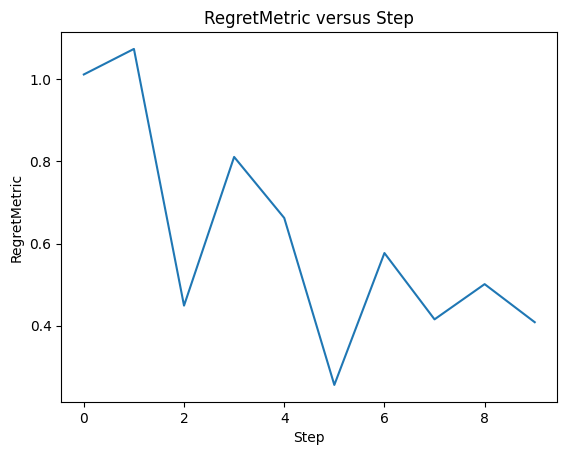

In [104]:
plot(metric_results, "RegretMetric")

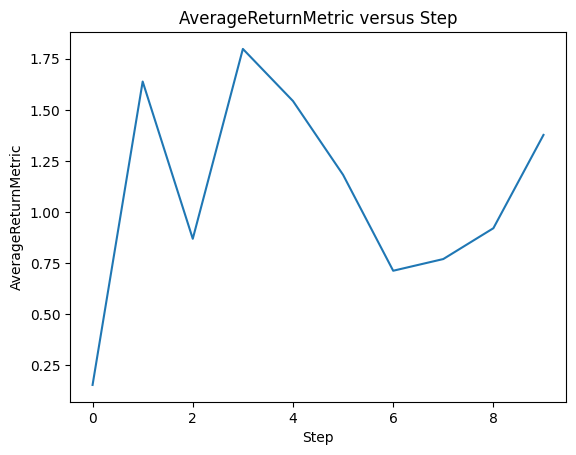

In [105]:
plot(metric_results, "AverageReturnMetric")

### Profiler

In [106]:
%load_ext tensorboard
# %reload_ext tensorboard

In [146]:
%tensorboard --logdir=$LOG_DIR

## load trained policy

In [118]:
ROOT_DIR

'gs://mabv1-hybrid-vertex-bucket/perarm-local-test/run-20230713-154556/root'

In [119]:
trained_policy = tf.saved_model.load(ROOT_DIR)
trained_policy

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7ff4b8f31ff0>

In [189]:
# observation_list = [list(np.ones(RANK_K + 2)) for _ in range(BATCH_SIZE)]
# observation_list

# batched_observations = {
#     GLOBAL_KEY:
#         tf.convert_to_tensor(combined_user_features, dtype=tf.float32),
#     PER_ARM_KEY:
#         tf.convert_to_tensor(current_movies, dtype=tf.float32),
# }

# batched_observations

observation_dict = {
    GLOBAL_KEY:
        np.zeros([BATCH_SIZE, RANK_K + 2], dtype=np.int32), #making space like above for dimensions
    PER_ARM_KEY:
        np.zeros([BATCH_SIZE, NUM_ACTIONS, RANK_K + 1], dtype=np.int32),
}

print(f"observation_dict  : {observation_dict}")

observation_dict  : {'global': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32), 'per_arm': array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 

In [191]:
time_step = tf_agents.trajectories.restart(
    observation=observation_dict,
    batch_size=tf.convert_to_tensor([BATCH_SIZE]),
)
time_step

TimeStep(
{'discount': array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 'observation': {'global': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32),
                 'per_arm': array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],

In [ ]:
action_step = trained_policy.action(time_step)
action_step.action.numpy().tolist()

In [184]:
observation_array = environment._observe()

time_step = tf_agents.trajectories.restart(
    observation=observation_array,
    batch_size=tf.convert_to_tensor([BATCH_SIZE]),
)

action_step = trained_policy.action(time_step)

action_step.action.numpy().tolist()

[10, 17, 10, 15, 0, 14, 1, 15]

In [122]:
observation_array = environment._observe()
observation_array

{'global': <tf.Tensor: shape=(8, 22), dtype=float32, numpy=
 array([[-1.2873987e-02, -2.1390352e-02,  4.6473794e-02,  1.2905279e-02,
          1.8002745e-02,  1.7323282e-02,  4.0619403e-02, -1.8831192e-03,
          3.5232522e-02, -4.7737733e-02,  3.5911977e-02,  2.8632969e-02,
          1.5208208e-03, -8.5478518e-03, -1.0778209e-02,  4.2909261e-02,
          4.1823767e-02,  2.3449438e-03, -2.0098533e-02,  5.6047082e-02,
          3.0000999e+00,  2.0000999e+00],
        [-1.7549284e-02,  3.1996551e-03,  1.8386850e-02,  1.2473919e-02,
          4.3198387e-03, -3.2752186e-02,  4.4371351e-03, -1.9762106e-02,
          1.8484747e-02, -2.2252942e-03,  1.6091483e-02,  1.3519984e-02,
         -1.0761653e-02,  8.0836611e-03, -1.6782213e-02, -4.3056097e-02,
          6.2738741e-03,  4.5072705e-02,  3.1135675e-02, -3.9139803e-02,
          2.0000999e+00,  6.0001001e+00],
        [-3.9113931e-02,  2.2795230e-02,  5.0533485e-02, -1.0424367e-02,
          2.6395298e-03,  4.1149292e-02, -3.2692634e-

In [123]:
import tf_agents

time_step = tf_agents.trajectories.restart(
    observation=observation_array,
    batch_size=tf.convert_to_tensor([BATCH_SIZE]),
)
time_step

TimeStep(
{'discount': <tf.Tensor: shape=(8,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>,
 'observation': {'global': <tf.Tensor: shape=(8, 22), dtype=float32, numpy=
array([[-1.2873987e-02, -2.1390352e-02,  4.6473794e-02,  1.2905279e-02,
         1.8002745e-02,  1.7323282e-02,  4.0619403e-02, -1.8831192e-03,
         3.5232522e-02, -4.7737733e-02,  3.5911977e-02,  2.8632969e-02,
         1.5208208e-03, -8.5478518e-03, -1.0778209e-02,  4.2909261e-02,
         4.1823767e-02,  2.3449438e-03, -2.0098533e-02,  5.6047082e-02,
         3.0000999e+00,  2.0000999e+00],
       [-1.7549284e-02,  3.1996551e-03,  1.8386850e-02,  1.2473919e-02,
         4.3198387e-03, -3.2752186e-02,  4.4371351e-03, -1.9762106e-02,
         1.8484747e-02, -2.2252942e-03,  1.6091483e-02,  1.3519984e-02,
        -1.0761653e-02,  8.0836611e-03, -1.6782213e-02, -4.3056097e-02,
         6.2738741e-03,  4.5072705e-02,  3.1135675e-02, -3.9139803e-02,
         2.0000999e+00,  6.0001001e+00

In [124]:
action_step = trained_policy.action(time_step)
action_step

PolicyStep(action=<tf.Tensor: shape=(8,), dtype=int32, numpy=array([18,  4, 18,  8, 18,  6, 17, 14], dtype=int32)>, state=(), info=PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=(), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=<tf.Tensor: shape=(8, 21), dtype=float32, numpy=
array([[-4.07728627e-02,  3.73689756e-02,  4.69364822e-02,
        -1.36779407e-02,  4.09221426e-02,  7.41495490e-02,
         2.38642823e-02, -2.87586208e-02,  7.93194398e-02,
        -9.33892429e-02, -6.31138384e-02,  1.45214591e-02,
        -2.04371829e-02, -3.38719003e-02, -3.12873907e-02,
         1.15584182e-02, -2.91644130e-03,  1.69797353e-02,
        -1.80372801e-02,  3.16854753e-02,  7.00010014e+00],
       [-9.31553021e-02,  2.30988413e-02, -4.64833453e-02,
        -4.15738858e-03, -4.10822546e-03, -1.66582465e-02,
         1.56104028e-01, -3.71573344e-02, -3.01199071e-02,
      

In [125]:
action_step = trained_policy.action(time_step)

action_step.action.numpy().tolist()

[18, 4, 18, 8, 18, 6, 17, 14]

In [126]:
action_step = trained_policy.action(time_step)

action_step.action.numpy().tolist()

[18, 4, 18, 8, 18, 6, 17, 14]

In [127]:
observation_array = environment._observe()

time_step = tf_agents.trajectories.restart(
    observation=observation_array,
    batch_size=tf.convert_to_tensor([BATCH_SIZE]),
)

action_step = trained_policy.action(time_step)

action_step.action.numpy().tolist()

[17, 3, 1, 19, 16, 6, 12, 5]

In [128]:
observation_array = environment._observe()

time_step = tf_agents.trajectories.restart(
    observation=observation_array,
    batch_size=tf.convert_to_tensor([BATCH_SIZE]),
)

action_step = trained_policy.action(time_step)

action_step.action.numpy().tolist()

[14, 0, 13, 17, 1, 3, 3, 2]

In [ ]:
environment._u_hat

sampled_user_ages = np.ones(BATCH_SIZE)
sampled_user_occ = np.ones(BATCH_SIZE)

SAMPLED_USER_INDICES = np.random.randint(NUM_USERS, size=BATCH_SIZE)
SAMPLED_USER_INDICES

combined_user_features = np.concatenate(
    (
        environment._u_hat[SAMPLED_USER_INDICES]
        , sampled_user_ages.reshape(-1,1)
        , sampled_user_occ.reshape(-1,1)
    )
    , axis=1
)

combined_user_features

###

import random

sampled_movie_indices = np.array([
    random.sample(range(environment._num_movies), environment._num_actions)
    for _ in range(environment._batch_size)
])

# current_users = combined_user_features.reshape([self.batch_size, self._rank_k+2])

movie_index_vector = sampled_movie_indices.reshape(-1)

flat_genre_list = environment._mov_gen_int[movie_index_vector] # shape of 1
flat_movie_list = environment._v_hat[movie_index_vector]       # shape of 2

combined_movie_features = np.concatenate(
    (
        flat_movie_list
        , flat_genre_list.reshape(-1,1)
    )
    , axis=1
)

current_movies = combined_movie_features.reshape(
    [environment._batch_size, environment._num_actions, environment._rank_k + 1]
)
current_movies
###

sampled_movie_indices.shape

observation_array = environment._observe()

time_step = tf_agents.trajectories.restart(
    observation=observation_array,
    batch_size=tf.convert_to_tensor([BATCH_SIZE]),
)

action_step = trained_policy.action(time_step)

action_step_np = action_step.action.numpy().tolist()
action_step_np

action_step.action
np.expand_dims(action_step.action, axis=-1)



sampled_movie_indices[:,action_step.action]
sampled_movie_indices[:,np.expand_dims(action_step.action, axis=-1)] # [:,action_step]